<a href="https://colab.research.google.com/github/StephenTGibson/MScDataSci_21-22/blob/main/COMP702-MScProject/PINNs_wave_eq_experimentation_trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.devitoproject.org/devito/index.html

In [1]:
# install devito
!pip install devito &> /dev/null

In [2]:
# import libraries and tools
import numpy as np
rng = np.random.default_rng()
import pandas as pd

from time import perf_counter

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
# from matplotlib.gridspec import GridSpec
import seaborn as sns

from google.colab import drive
drive.mount('/content/gdrive')
hyperParas=pd.read_csv('/content/gdrive/My Drive/testRecord.csv', index_col=0)

import torch
from torch import nn

from devito import Grid, TimeFunction, Operator, Constant, Eq, solve, first_derivative, left

from examples.seismic import Model, plot_velocity
from examples.seismic import TimeAxis
from examples.seismic import RickerSource
from examples.seismic import Receiver

import sys
!git clone https://github.com/StephenTGibson/MScDataSci_21-22.git
sys.path.append('/content/MScDataSci_21-22/COMP702-MScProject')
import utilityFunctions

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

Mounted at /content/gdrive
Cloning into 'MScDataSci_21-22'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (230/230), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 418 (delta 138), reused 210 (delta 127), pack-reused 188
Receiving objects: 100% (418/418), 14.17 MiB | 10.85 MiB/s, done.
Resolving deltas: 100% (253/253), done.


device(type='cuda', index=0)

## General definition

In [3]:
xLimit_m = 1.e3 ### METRES ###
zLimit_m = 1.e3 ### METRES ###
tLimit_s = 0.5 ### SECONDS ###

## Devito

In [4]:
nx = 200 ### NODES ###
nz = 200 ### NODES ###

absorbingLayer = 10 ### NODES ###

dx = xLimit_m / (nx-1) ### METRES ###
dz = zLimit_m / (nz-1) ### METRES ###

xRange = np.arange(0, nx*dx, dx)
zRange = np.arange(0, nz*dz, dz)
xGrid, zGrid = np.meshgrid(xRange, zRange)

origin = (0., 0.)
spacing = (dx, dz)
shape = (nx, nz)

v = np.empty(shape, dtype=np.float32)
v[:] = 1. ### KM/S ###
# v[:, int(nz*0.5):] = 1.5  ### KM/S ###

devitoModel = Model(vp=v,
                    origin=origin,
                    shape=shape,
                    spacing=spacing,
                    space_order=2,
                    nbl=absorbingLayer,
                    bcs='damp',
                    )

dt = devitoModel.critical_dt
tLimit_ms = tLimit_s * 1e3 ### MILLISECONDS ###
nt = tLimit_ms / dt
timeRange = TimeAxis(start=0, stop=tLimit_ms, step=dt)

u = TimeFunction(name='u',
                 grid=devitoModel.grid,
                 time_order=2,
                 space_order=2,
                 save=int(nt)+2,
                 )

pde = devitoModel.m * u.dt2 - u.laplace + devitoModel.damp * u.dt
stencil = Eq(u.forward, solve(pde, u.forward))

f0 = 0.01 ### kHZ ###
source = RickerSource(name='src',
                      grid=devitoModel.grid,
                      f0=f0,
                      npoint=1,
                      time_range=timeRange,
                      )

source.coordinates.data[0, 0] = int(xLimit_m*0.5) ### METRES ###
source.coordinates.data[0, 1] = int(zLimit_m*0.5) ### METRES ###

sourceTerm = source.inject(field=u.forward, expr=source * dt**2 / devitoModel.m)

op = Operator([stencil] + sourceTerm, subs=devitoModel.spacing_map)

Operator `initdamp` ran in 0.01 s
INFO:Devito:Operator `initdamp` ran in 0.01 s
Operator `pad_vp` ran in 0.01 s
INFO:Devito:Operator `pad_vp` ran in 0.01 s


# Define medium

In [5]:
# log start time to measure performance
startTime = perf_counter()

# generate solution
summary = op.apply(time=int(nt), dt=dt)

# log end time to measure performance
endTime = perf_counter()
# print total training time
print(f'Training duration: {(endTime-startTime):.2f}s')

FD_solutionWithSrc = np.array(u.data[:,
                              absorbingLayer:u.data.shape[1]-absorbingLayer,
                              absorbingLayer:u.data.shape[2]-absorbingLayer
                              ])
FD_solutionWithSrc.shape

Operator `Kernel` ran in 0.02 s
INFO:Devito:Operator `Kernel` ran in 0.02 s


Training duration: 0.32s


(164, 200, 200)

# PINN

PDE loss term is 20,000 points  
while 3,600 points are set for each of the early-time snapshot data

NsxArray consists of Nsx randomly sampled points from time sx (t, x, z, u)

In [253]:
# define physics informed neural network for 1D Burgers' equation
class PINN_2D_AcousticWave(torch.nn.Module):
    def __init__(self,
                 hiddenLayers,
                 nodesPerLayer,
                 activationFunction,
                 uTrain,
                 uTrainDeltas,
                 maxArray,
                 NuTotal,
                 NfTotal,
                 trainingResample,
                 NuRange,
                 maxIterations,
                 maxEvaluations,
                 l1,
                 l2,
                 verbose = True
                 ):
        super(PINN_2D_AcousticWave, self).__init__()
        # network structure
        self.layers = torch.nn.ModuleList()
        self.activationFunction = activationFunction
        # input layer
        self.layers.append(torch.nn.Linear(3, nodesPerLayer))
        # hidden layers
        for _ in range(hiddenLayers):
            self.layers.append(torch.nn.Linear(nodesPerLayer, nodesPerLayer))
        # output layer
        self.layers.append(torch.nn.Linear(nodesPerLayer, 1))

        self.uTrain = uTrain
        self.uTrainDeltas = uTrainDeltas

        self.maxArray = maxArray

        self.inputMax = max(maxArray[0]*1.e3, maxArray[1], maxArray[2])
        # self.maxArray[-1] = uTrain.max()
        self.uMax = uTrain.max()
        self.uMin = uTrain.min()
        
        self.NuTotal = NuTotal
        self.NfTotal = NfTotal

        self.trainingResample = trainingResample
        self.NuRange = NuRange

        self.l1 = l1
        self.l2 = l2

        self.trainTime = 0.
        self.history = np.empty((0,3), float)        

        # boolean whether to print update during training
        self.verbose = verbose

        self.AdamOptimiser = torch.optim.Adam(
            self.parameters(),
            # lr=1.e-4, # default lr=0.001, 
            )

        # define L-BFGS optimiser
        self.LBFGS_optimiser = torch.optim.LBFGS(
            self.parameters(),
            max_iter=maxIterations,
            max_eval=maxEvaluations,
            # tolerance_grad=1e-8, # (default: 1e-5)
            # tolerance_change=1e-11, # (default: 1e-9)
            # history_size=1, # default: 100
            # tolerance_change= 1.0 * np.finfo(float).eps,
            line_search_fn='strong_wolfe',
            )

    def createNf(self, tLim):
        # create collocation training points selected uniformly randomly across input domain: t - x - z
        Nf = np.array([
            rng.uniform(-1, 1, self.NfTotal),
            rng.uniform(-1, 1, self.NfTotal),
            rng.uniform(-1, 1, self.NfTotal),
        ]).T

        Nf[:,0] = Nf[:,0] * (self.maxArray[0]*1.e3 / self.inputMax)

        # Nf[:,1] = Nf[:,1] * (self.maxArray[1] / self.inputMax)
        # Nf[:,2] = Nf[:,2] * (self.maxArray[2] / self.inputMax)

        return torch.from_numpy(Nf.astype(np.float32)).requires_grad_().to(device)

    def createNu(self):
        if self.NuRange:
            Nu = np.array([
                rng.choice(self.uTrain.shape[0], self.NuTotal, replace=True),
                rng.choice(self.uTrain.shape[1], self.NuTotal, replace=True),
                rng.choice(self.uTrain.shape[2], self.NuTotal, replace=True),
                np.zeros(self.NuTotal)
                ]).astype(float).T
            Nu[:,3] = self.uTrain[
                Nu[:,0].astype(int),
                Nu[:,1].astype(int),
                Nu[:,2].astype(int)]
            Nu[:,:3] *= self.uTrainDeltas
        else:
            N = int(self.NuTotal*0.5)
            Nu1 = np.array([
                        np.zeros(N),
                        rng.choice(self.uTrain.shape[1], N, replace=True),
                        rng.choice(self.uTrain.shape[2], N, replace=True),
                        np.zeros(N),
                     ]).astype(float).T
            Nu1[:,3] = self.uTrain[0][
                            Nu1[:,1].astype(int),
                            Nu1[:,2].astype(int)]
            Nu1[:,:3] *= self.uTrainDeltas
            Nu2 = np.array([
                        np.ones(N) * (self.uTrain.shape[0] - 1),
                        rng.choice(self.uTrain.shape[1], N, replace=True),
                        rng.choice(self.uTrain.shape[2], N, replace=True),
                        np.zeros(N),
                     ]).astype(float).T
            Nu2[:,3] = self.uTrain[-1][
                                Nu2[:,1].astype(int),
                                Nu2[:,2].astype(int)]
            Nu2[:,:3] *= self.uTrainDeltas

            Nu = np.concatenate([Nu1, Nu2])

        # normalise
        Nu[:,:-1] = 2 * Nu[:,:-1] / self.maxArray[:-1] - 1

        Nu[:,0] = Nu[:,0] * (self.maxArray[0]*1.e3 / self.inputMax)

        # Nu[:,1] = Nu[:,1] * (self.maxArray[1] / self.inputMax)
        # Nu[:,2] = Nu[:,2] * (self.maxArray[2] / self.inputMax)

        Nu[:,-1] = 2 * (Nu[:,-1] - self.uMin) / (self.uMax - self.uMin) - 1

        return torch.from_numpy(Nu[:,:-1].astype(np.float32)).requires_grad_().to(device),\
                    torch.from_numpy(Nu[:,-1].astype(np.float32)).to(device)

    # compute solution via forward pass
    def forward(self, X):
        input = X
        for layer in self.layers[:-1]:
            input = self.activationFunction(layer(input))
        return self.layers[-1](input).flatten()

    # compute PDE residual
    def residual(self, X, m):
        t = X[:,0]
        x = X[:,1]
        z = X[:,2]
        X = torch.stack((t,x,z)).T
        # compute solution
        u = self.forward(X)
        du_dNf = torch.autograd.grad(u, X, torch.ones_like(u), create_graph=True)[0]
        d2u_dt2 = torch.autograd.grad(du_dNf[:,0], t, torch.ones_like(u), create_graph=True)[0]
        d2u_dx2 = torch.autograd.grad(du_dNf[:,1], x, torch.ones_like(u), create_graph=True)[0]
        d2u_dz2 = torch.autograd.grad(du_dNf[:,2], z, torch.ones_like(u), create_graph=True)[0]

        # compute PDE residual
        return d2u_dt2 - m**2 * (d2u_dx2 + d2u_dz2)

    def medium(self, Nf):

        m = torch.ones(Nf.shape[0]).to(device) + (Nf[:,2] > 0) * 0.5

        m = m / m.max()

        return m

    def lossFunc(self, Nu_pred, Nu_targ, Nf_r):
        self.iterationCount += 1
        # compute constituent loss components
        NuLoss = torch.mean(torch.square(Nu_pred - Nu_targ))
        # if Nf_r != None:
        # print(Nf_r.shape)
        NfLoss = torch.mean(torch.square(Nf_r))
        # else:
        #     NfLoss = torch.tensor([0.]).to(device)
        totalLoss = self.l2*NuLoss + self.l1*NfLoss
        # totalLoss = self.l2*NuLoss
        # store losses
        self.history = np.append(self.history,
                                 np.array([
                                           [totalLoss.item()],
                                           [NuLoss.item()],
                                           [NfLoss.item()],
                                           ]).T,
                                 axis=0)
        # print training progress update (every (2**2)th epoch initially, then every 1000th)
        if self.verbose and ((np.log2(self.iterationCount) % 1 == 0 and self.iterationCount < 1000) or self.iterationCount % 1000 == 0):
            seconds = perf_counter() - self.startTime
            print(f'Epoch: {self.iterationCount} --- Elapsed time: {int(seconds/60)}m{int(seconds%60)}s --- Loss: {self.history[-1,0]}')
        return totalLoss

    def Adam_trainer(self, epochs, epochsNuOnly):
        self.train()
        self.iterationCount = 0
        self.startTime = perf_counter()

        tLim = self.maxArray[0]

        Nf = self.createNf(tLim)
        Nu, Nu_targ = self.createNu()

        m = 1. #self.medium(Nf)

        for epoch in range(epochs):
            self.AdamOptimiser.zero_grad()
            Nu_pred = self.forward(Nu)

            if epoch > epochsNuOnly:
                Nf_r = self.residual(Nf, m)
            else:
                Nf_r = torch.tensor([0.]).to(device)
            lossValue = self.lossFunc(Nu_pred, Nu_targ, Nf_r)
            lossValue.backward()
            self.AdamOptimiser.step()
            if self.trainingResample:
                Nf = self.createNf(tLim)
                Nu, Nu_targ = self.createNu()
        self.eval()
        self.trainTime += (perf_counter() - self.startTime)
    
    def LBFGS_trainer(self):
        # set to train mode
        self.train()
        # initialise variables to track progress
        self.iterationCount = 0
        self.startTime = perf_counter()
        # Prepare training tensors
        tLim = self.maxArray[0]

        Nf = self.createNf(tLim)
        Nu, Nu_targ = self.createNu()

        m = 1. #self.medium(Nf)

        # define closure function for L-BFGS optimiser
        def closure():
            self.LBFGS_optimiser.zero_grad()
            Nu_pred = self.forward(Nu)
            Nf_r = self.residual(Nf, m)
            lossValue = self.lossFunc(Nu_pred, Nu_targ, Nf_r)
            lossValue.backward()
            return lossValue
        # define closure function for L-BFGS optimiser
        def closureResample():
            Nf = self.createNf(tLim)
            Nu, Nu_targ = self.createNu()
            self.LBFGS_optimiser.zero_grad()
            Nu_pred = self.forward(Nu)
            Nf_r = self.residual(Nf, m)
            lossValue = self.lossFunc(Nu_pred, Nu_targ, Nf_r)
            lossValue.backward()
            return lossValue

        # run optimiser
        if self.trainingResample:
            self.LBFGS_optimiser.step(closureResample)
        else:
            self.LBFGS_optimiser.step(closure)
        # training complete, set to evaluation mode
        self.eval()
        self.trainTime += (perf_counter() - self.startTime)

    def generateOutput(self, FD_solution_nt):

        t = np.arange(0, FD_solution_nt) * self.uTrainDeltas[0]
        x = np.arange(0, self.maxArray[1] + self.uTrainDeltas[1], self.uTrainDeltas[1])
        z = np.arange(0, self.maxArray[2] + self.uTrainDeltas[2], self.uTrainDeltas[2])

        T, X, Z = np.meshgrid(t, x, z, indexing='ij')

        N = np.stack((T.flatten(), X.flatten(), Z.flatten())).T

        N = 2 * N / self.maxArray[:-1] - 1

        N[:,0] = N[:,0] * self.maxArray[0]

        U = self.forward(torch.from_numpy(N.astype(np.float32)).to(device)).cpu().detach().numpy()

        U = (U + 1.) * 0.5 * (self.uMax - self.uMin) + self.uMin

        return np.reshape(U, (t.shape[0], x.shape[0], z.shape[0]))

In [314]:
testNumber = hyperParas.shape[0]+1
# define network characteristics
hiddenLayers = 4
nodesPerLayer = 30
activationFunction = nn.Tanh()
actFuncDf = 'Tanh'

uTrainSlices = 10
sourceEndTime = 2/f0 ### MILLISECONDS ###
fdSliceStart = int(sourceEndTime/dt) + 1
FD_solution = FD_solutionWithSrc[fdSliceStart:]

uTrain = FD_solution[:uTrainSlices]

uTrainDeltas = np.array([
    dt*1e-3,
    dx,
    dz,])
maxArray = np.array([
    FD_solution.shape[0] * dt * 1e-3,
    xLimit_m,
    zLimit_m,
    0.,])

NuTotal = 7200
NfTotal = 20000
trainingResample = True
NuRange = True
maxIterations = 50000
maxEvaluations = 50000
l1 = 0.01 # residual (PDE)
l2 = 1. # snapshots

model = PINN_2D_AcousticWave(hiddenLayers, nodesPerLayer, activationFunction,
                             uTrain, uTrainDeltas, maxArray,
                             NuTotal, NfTotal,
                             trainingResample, NuRange,
                             maxIterations, maxEvaluations,
                             l1, l2)

parasDf = sum(p.numel() for p in model.parameters())
print(f'Network parameters: {parasDf}')

model = model.to(device)

Network parameters: 3871


In [ ]:
# model.LBFGS_trainer()
# optDf = 'LBFGS'

model.Adam_trainer(40000, 0)
optDf = 'Adam'

Epoch: 1 --- Elapsed time: 0m0s --- Loss: 0.022783435881137848
Epoch: 2 --- Elapsed time: 0m0s --- Loss: 0.023563191294670105
Epoch: 4 --- Elapsed time: 0m0s --- Loss: 0.02131996862590313
Epoch: 8 --- Elapsed time: 0m0s --- Loss: 0.02293523959815502
Epoch: 16 --- Elapsed time: 0m0s --- Loss: 0.021450700238347054
Epoch: 32 --- Elapsed time: 0m0s --- Loss: 0.021766969934105873
Epoch: 64 --- Elapsed time: 0m1s --- Loss: 0.02226889133453369
Epoch: 128 --- Elapsed time: 0m2s --- Loss: 0.02329210564494133
Epoch: 256 --- Elapsed time: 0m5s --- Loss: 0.02252325974404812
Epoch: 512 --- Elapsed time: 0m10s --- Loss: 0.021975602954626083
Epoch: 1000 --- Elapsed time: 0m19s --- Loss: 0.024964680895209312
Epoch: 2000 --- Elapsed time: 0m39s --- Loss: 0.02476820908486843
Epoch: 3000 --- Elapsed time: 0m58s --- Loss: 0.021954741328954697


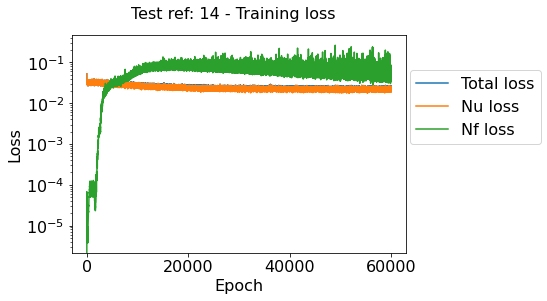

In [316]:
fig = utilityFunctions.trainingHistoryPlot(model.history,
                                           ['Total loss', 'Nu loss', 'Nf loss'],
                                           'Loss',
                                           f'Test ref: {testNumber} - Training loss',
                                           yLogAx=True,
                                           )

plt.savefig(f'/content/gdrive/My Drive/TestRef:{testNumber}_loss_curve:_2d_wave_trials', bbox_inches='tight')

In [317]:
torch.cuda.empty_cache()
PINN_solution = model.generateOutput(FD_solution.shape[0])

difference_solution = FD_solution-PINN_solution

## Plots
Compute u from PINN for all t, x, z in same results form as Devito (np array: t-z-x)

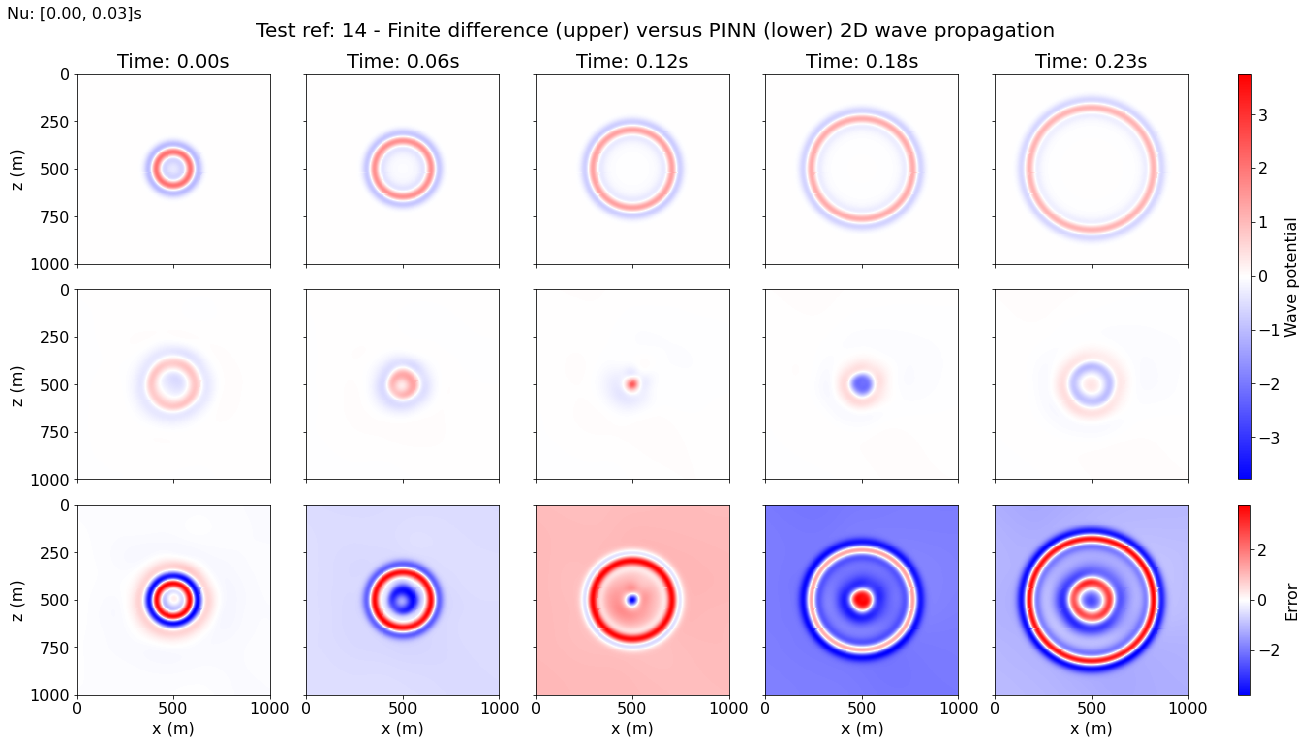

In [318]:
numPlots = 5

norm = matplotlib.colors.Normalize(min(FD_solution.min(), PINN_solution.min()), max(FD_solution.max(), PINN_solution.max()))
cmap = matplotlib.cm.get_cmap('bwr')
mapping = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
fig, axs = plt.subplots(3, numPlots,
                        figsize=(18, 10),
                        constrained_layout=True,
                        sharex=True,
                        sharey=True,
                        )
axs[0,0].invert_yaxis()

for idx, ax in enumerate(axs[0]):
    plot = ax.pcolormesh(xGrid, zGrid, FD_solution[idx * int(FD_solution.shape[0]/numPlots)].T, norm=norm, cmap='bwr')
    if idx == 0:
        # ax.axhline(y=0.5e3, xmin=0., xmax=1.e3, linewidth=1, color = 'k', linestyle='--')
        # ax.text(40, 400, '1km/s')
        # ax.text(40, 900, '1.5km/s')
        ax.set_ylabel('z (m)')
    ax.set_title(f'Time: {(uTrainDeltas[0] * idx * int(FD_solution.shape[0]/numPlots)):.2f}s')
for idx, ax in enumerate(axs[1]):    
    plot = ax.pcolormesh(xGrid, zGrid, PINN_solution[idx * int(PINN_solution.shape[0]/numPlots)].T, cmap='bwr', norm=norm)
    # ax.set_xlabel('x (m)')
    if idx == 0:
        ax.set_ylabel('z (m)')
clb = fig.colorbar(mapping, ax=axs[:2].ravel(), aspect=60)
clb.set_label('Wave potential')

normErr = matplotlib.colors.Normalize(difference_solution.min(), difference_solution.max())
# cmap = matplotlib.cm.get_cmap('bwr')
mappingErr = matplotlib.cm.ScalarMappable(norm=normErr, cmap=cmap)
for idx, ax in enumerate(axs[2]):    
    plot = ax.pcolormesh(xGrid, zGrid, difference_solution[idx * int(difference_solution.shape[0]/numPlots)].T, cmap='bwr')
    ax.set_xlabel('x (m)')
    if idx == 0:
        ax.set_ylabel('z (m)')
clbErr = fig.colorbar(mappingErr, ax=axs[2].ravel(), aspect=30)
clbErr.set_label('Error')

fig.text(0., 1., f'Nu: [0.00, {(uTrainDeltas[0] * uTrainSlices):.2f}]s')

fig.suptitle(f'Test ref: {testNumber} - Finite difference (upper) versus PINN (lower) 2D wave propagation', fontsize=20)
plt.savefig(f'/content/gdrive/My Drive/Test_ref:{testNumber}_2d_wave_prop', bbox_inches='tight')
plt.show()

In [319]:
relativeL2error = np.linalg.norm(FD_solution-PINN_solution) / np.linalg.norm(FD_solution)
relativeL2error

1.1371129

In [320]:
hyperParas = hyperParas.append({
    'Test ref#': testNumber,
    'Hidden layers': hiddenLayers,
    'Nodes per hidden layer': nodesPerLayer,
    'Learnable parameters': parasDf,
    'Activation function': actFuncDf,
    'Nu': NuTotal,
    'Nf': NfTotal,
    'Nu coefficient': l2,
    'Nf coefficient': l1,
    'Optimiser': optDf,
    'Nu range size' : uTrainSlices,
    'Nu range continuous': NuRange,
    'Resampling': trainingResample,
    'Terminating epoch': model.history.shape[0],
    'Terminating loss': model.history[-1, 0],
    'Training duration': model.trainTime,
    'Relative L2 error': relativeL2error,
    },
    ignore_index=True)

hyperParas.to_csv('/content/gdrive/My Drive/testRecord.csv')

In [313]:
hyperParas

,Test ref#,Hidden layers,Nodes per hidden layer,Activation function,Learnable parameters,Nu,Nf,Nu coefficient,Nf coefficient,Optimiser,Nu range size,Nu range continuous,Resampling,Terminating epoch,Terminating loss,Training duration,Relative L2 error
0,1,4,50,Tanh,10451,7200,20000,1.0,0.1,LBFGS,10,False,False,15637,0.000369,801.577216,0.094218
1,2,4,30,Tanh,3871,7200,20000,1.0,0.1,LBFGS,10,False,False,14152,0.000644,388.426742,0.150702
2,3,2,42,Tanh,3823,7200,20000,1.0,0.1,LBFGS,10,False,False,24773,0.001377,621.151384,0.226948
3,4,4,25,Tanh,2726,7200,20000,1.0,0.1,LBFGS,10,False,False,12077,0.000271,308.386384,0.092116
4,5,4,30,ReLU,3871,7200,20000,1.0,0.1,LBFGS,10,False,False,3301,0.000111,65.949251,2.636981
5,6,4,30,LeakyReLU,3871,7200,20000,1.0,0.1,LBFGS,10,False,False,4529,0.000888,85.590435,14.484820
6,7,4,30,Softplus,3871,7200,20000,1.0,1.0,Adam,10,False,False,20000,0.031463,458.883943,14.484820
7,8,4,30,Tanh,3871,7200,20000,1.0,0.1,Adam,10,False,False,10000,0.032938,185.861738,1.001636
8,9,4,30,Tanh,3871,7200,20000,1.0,0.1,Adam,10,False,False,60000,0.018217,1100.690023,0.810883
9,10,4,30,Tanh,3871,7200,20000,1.0,0.1,Adam,10,False,False,40000,0.009655,736.618326,0.584695
